In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.detectorRB import detect_anomalies_RB
from utils.flag_anomaly import or_based, and_based
from utils.savefile import savefile

In [11]:
df = pd.read_csv("data/anomalies.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)


In [12]:
df

,User,ID,Process,FKL_Process,Rule1,Time1,Anomaly
Datetime,,,,,,,
2022-12-31 20:07:03,S398,64901,Login,16,False,False,False
2022-12-31 20:22:35,S314,30838,Login,13,False,False,False
2022-12-31 20:31:50,S612,44993,Login,15,True,False,True
2022-12-31 20:36:39,S414,69111,Login,8,True,False,True
2022-12-31 20:41:04,S960,52703,Login,10,True,False,True
...,...,...,...,...,...,...,...
2023-11-28 22:41:41,J992,76378,Login,10,True,False,True
2023-11-28 22:43:01,S688,69689,Login,9,True,False,True
2023-11-28 22:45:37,J424,27518,Login,15,True,False,True


In [13]:
df.index = pd.to_datetime(df.index).round("h")
df.index.name = "Datetime"
df["is_failed"] = df["FKL_Process"].isin([8, 16])  # Define fail codes

# Group by User and Date
summary = df.groupby(["Datetime"]).agg(
    total_logins=("Process", "count"),
    failed_logins=("is_failed", "sum"),
    Rule1=("Rule1", "any"),
    Time1=("Time1", "any"),
    Anomaly=("Anomaly", "any")  # label for training
).reset_index()

summary["fail_ratio"] = summary["failed_logins"] / summary["total_logins"]
summary['Anomaly'] &= (summary['fail_ratio'] > 0.4) & (summary['failed_logins'] > 5) # Added condition if, fail_ratio as well as number of fails are high


In [14]:
summary

,Datetime,total_logins,failed_logins,Rule1,Time1,Anomaly,fail_ratio
0,2022-12-31 20:00:00,2,1,False,False,False,0.500000
1,2022-12-31 21:00:00,6,1,True,False,False,0.166667
2,2022-12-31 22:00:00,3,0,True,False,False,0.000000
3,2022-12-31 23:00:00,1,0,True,False,False,0.000000
4,2023-01-01 04:00:00,2,0,True,False,False,0.000000
...,...,...,...,...,...,...,...
7396,2023-11-28 20:00:00,2,1,False,False,False,0.500000
7397,2023-11-28 21:00:00,1,0,False,False,False,0.000000
7398,2023-11-28 22:00:00,4,0,True,False,False,0.000000
7399,2023-11-28 23:00:00,6,0,True,False,False,0.000000


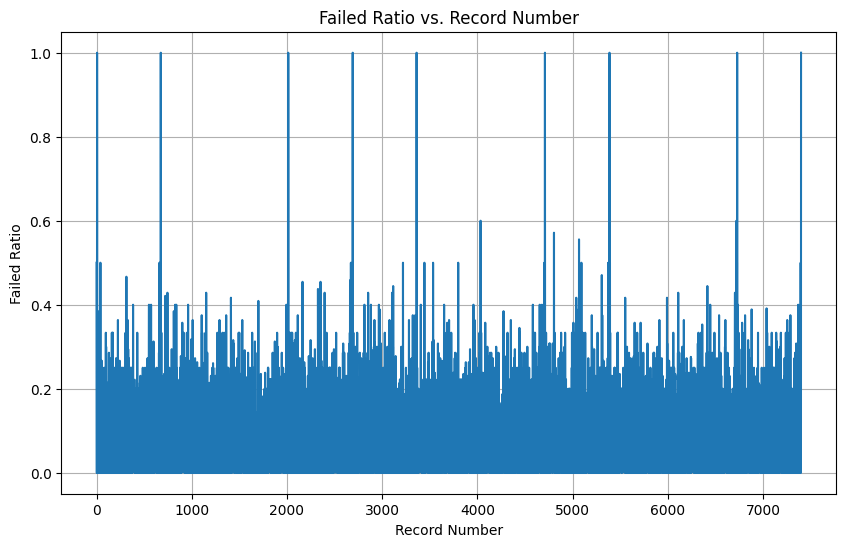

In [15]:
plt.figure(figsize=(10, 6)) 
plt.plot(summary['fail_ratio'])
plt.xlabel("Record Number")
plt.ylabel("Failed Ratio")
plt.title("Failed Ratio vs. Record Number")
plt.grid(True)
plt.show()

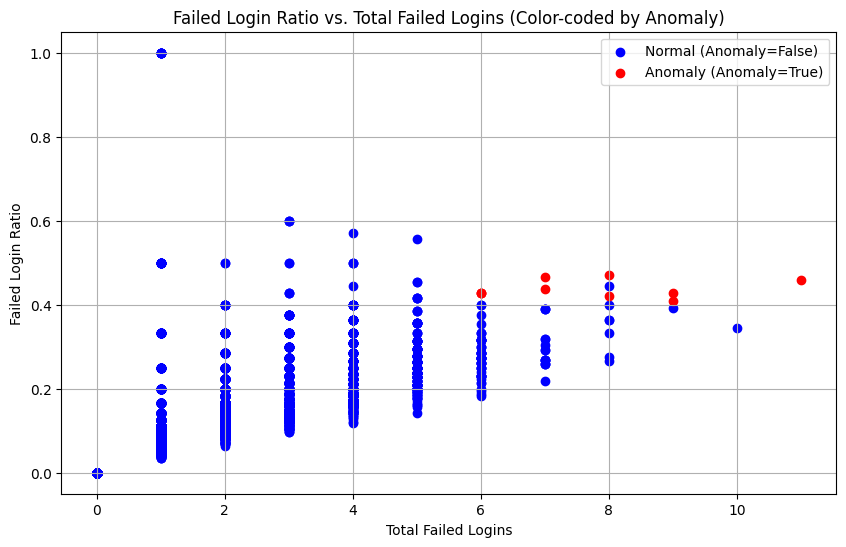

In [16]:
anomalies = summary[summary['Anomaly'] == True]
normal = summary[summary['Anomaly'] == False]

plt.figure(figsize=(10, 6))
plt.scatter(normal['failed_logins'], normal['fail_ratio'], c='blue', label='Normal (Anomaly=False)')
plt.scatter(anomalies['failed_logins'], anomalies['fail_ratio'], c='red', label='Anomaly (Anomaly=True)')

plt.xlabel("Total Failed Logins")
plt.ylabel("Failed Login Ratio")
plt.title("Failed Login Ratio vs. Total Failed Logins (Color-coded by Anomaly)")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
normal

,Datetime,total_logins,failed_logins,Rule1,Time1,Anomaly,fail_ratio
0,2022-12-31 20:00:00,2,1,False,False,False,0.500000
1,2022-12-31 21:00:00,6,1,True,False,False,0.166667
2,2022-12-31 22:00:00,3,0,True,False,False,0.000000
3,2022-12-31 23:00:00,1,0,True,False,False,0.000000
4,2023-01-01 04:00:00,2,0,True,False,False,0.000000
...,...,...,...,...,...,...,...
7396,2023-11-28 20:00:00,2,1,False,False,False,0.500000
7397,2023-11-28 21:00:00,1,0,False,False,False,0.000000
7398,2023-11-28 22:00:00,4,0,True,False,False,0.000000
7399,2023-11-28 23:00:00,6,0,True,False,False,0.000000


In [18]:
anomalies

,Datetime,total_logins,failed_logins,Rule1,Time1,Anomaly,fail_ratio
314,2023-01-14 02:00:00,15,7,True,False,True,0.466667
722,2023-02-03 01:00:00,19,8,True,False,True,0.421053
745,2023-02-04 00:00:00,21,9,True,False,True,0.428571
1152,2023-02-20 23:00:00,14,6,True,False,True,0.428571
1700,2023-03-15 22:00:00,22,9,True,False,True,0.409091
2326,2023-04-13 23:00:00,16,7,True,False,True,0.437500
2396,2023-04-16 21:00:00,14,6,True,False,True,0.428571
2663,2023-04-28 00:00:00,24,11,True,False,True,0.458333
2853,2023-05-07 21:00:00,14,6,True,False,True,0.428571
5307,2023-08-25 23:00:00,17,8,True,False,True,0.470588
